# Introduction
In this notebook, we created the dataset class used to feed slices and corresponding segmentation masks to the network during training.

## Imports

* pathlib for easy path handling
* torch for dataset creation
* numpy for file loading and processing
* imgaug for data augmentation
* matplotlib for demo

In [1]:
#!pip install --no-cache-dir numpy==1.26.4 scipy==1.11.4 imgaug==0.4.0 opencv-python==4.8.1.78

In [2]:
from pathlib import Path

import torch
import numpy as np
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import matplotlib.pyplot as plt

## DataSet Creation
We implemented the following functionality:
1. Create a list of all 2D slices. To so we need to extract all slices from all subjects
2. Extract the corresponding label path for each slice path
3. Load slice and label
4. Data Augmentation. Make sure that slice and mask are augmented identically. imgaug handles this for us, thus we will not use torchvision.transforms for that
5. Return slice and mask

In [3]:
from pathlib import Path
import torch
import numpy as np
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

class LungDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params, base_seed: int | None = None):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
        self.base_seed = int(base_seed) if base_seed is not None else None

    @staticmethod
    def extract_files(root):
        files = []
        for subject in root.glob("*"):
            for slc in (subject / "data").glob("*"):
                files.append(slc)
        return files

    @staticmethod
    def change_img_to_label_path(path):
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def augment(self, img2d, mask2d):
        # segmap must be bool/int for imgaug
        seg = SegmentationMapsOnImage(mask2d.astype(np.uint8, copy=False), shape=img2d.shape)
        img_aug, seg_aug = self.augment_params(image=img2d.astype(np.float32, copy=False),
                                               segmentation_maps=seg)
        mask_aug = seg_aug.get_arr().astype(np.float32, copy=False)  # back to float for loss
        return img_aug, mask_aug

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)

        img  = np.load(file_path).astype(np.float32, copy=False)  # (H,W) float32
        mask = np.load(mask_path)                                  # (H,W)

        if self.augment_params:
            if self.base_seed is not None:
                imgaug.seed(self.base_seed + int(idx))             # reproducible per index
            img, mask = self.augment(img, mask)
        else:
            mask = mask.astype(np.float32, copy=False)

        # return (1,H,W) **tensors** (float32) for model/BCEWithLogitsLoss
        img_t  = torch.from_numpy(img).unsqueeze(0)                # torch.float32
        mask_t = torch.from_numpy(mask).unsqueeze(0)               # torch.float32
        return img_t, mask_t

Define the data augmentation routine corresponding of scaling and rotation.

In [4]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)),  # rotate up to 45 degrees
    iaa.ElasticTransformation()
                ])

In [5]:
# Mount Google Drive (safe to run multiple times in Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    print("Google Drive mounted at /content/drive")
except Exception as e:
    print("Not running in Colab or drive already mounted. Proceeding…", e)

# Create the dataset object
BASE = Path("/content/drive/MyDrive/CIS 5810/LA-NSCLC dataset/selected_150_split")
path = BASE / "Preprocessed_for_2D_Unet/train"

print(f"BASE exists? {BASE.exists()} -> {BASE}")
print(f"path exists? {path.exists()} -> {path}")

# Optional: quick peek at layout
if path.exists():
    some_data = list(path.glob("*/data/*.npy"))[:5]
    some_masks = list(path.glob("*/masks/*.npy"))[:5]
    print("Sample data files:", [p.as_posix() for p in some_data])
    print("Sample mask files:", [p.as_posix() for p in some_masks])

# Instantiate your dataset (assumes LungDataset and `seq` are defined)
dataset = LungDataset(path, seq, base_seed=42)  # same idx yields same augmented result across runs
print("Dataset size:", len(dataset))

Mounted at /content/drive
Google Drive mounted at /content/drive
BASE exists? True -> /content/drive/MyDrive/CIS 5810/LA-NSCLC dataset/selected_150_split
path exists? True -> /content/drive/MyDrive/CIS 5810/LA-NSCLC dataset/selected_150_split/Preprocessed_for_2D_Unet/train
Sample data files: ['/content/drive/MyDrive/CIS 5810/LA-NSCLC dataset/selected_150_split/Preprocessed_for_2D_Unet/train/0/data/0.npy', '/content/drive/MyDrive/CIS 5810/LA-NSCLC dataset/selected_150_split/Preprocessed_for_2D_Unet/train/0/data/1.npy', '/content/drive/MyDrive/CIS 5810/LA-NSCLC dataset/selected_150_split/Preprocessed_for_2D_Unet/train/0/data/2.npy', '/content/drive/MyDrive/CIS 5810/LA-NSCLC dataset/selected_150_split/Preprocessed_for_2D_Unet/train/0/data/3.npy', '/content/drive/MyDrive/CIS 5810/LA-NSCLC dataset/selected_150_split/Preprocessed_for_2D_Unet/train/0/data/4.npy']
Sample mask files: ['/content/drive/MyDrive/CIS 5810/LA-NSCLC dataset/selected_150_split/Preprocessed_for_2D_Unet/train/0/masks/0.n

Visualize our dataset. To make sure that the augmentation works, we accessed the same element multiple times and checked whether the segmentation masks fit.

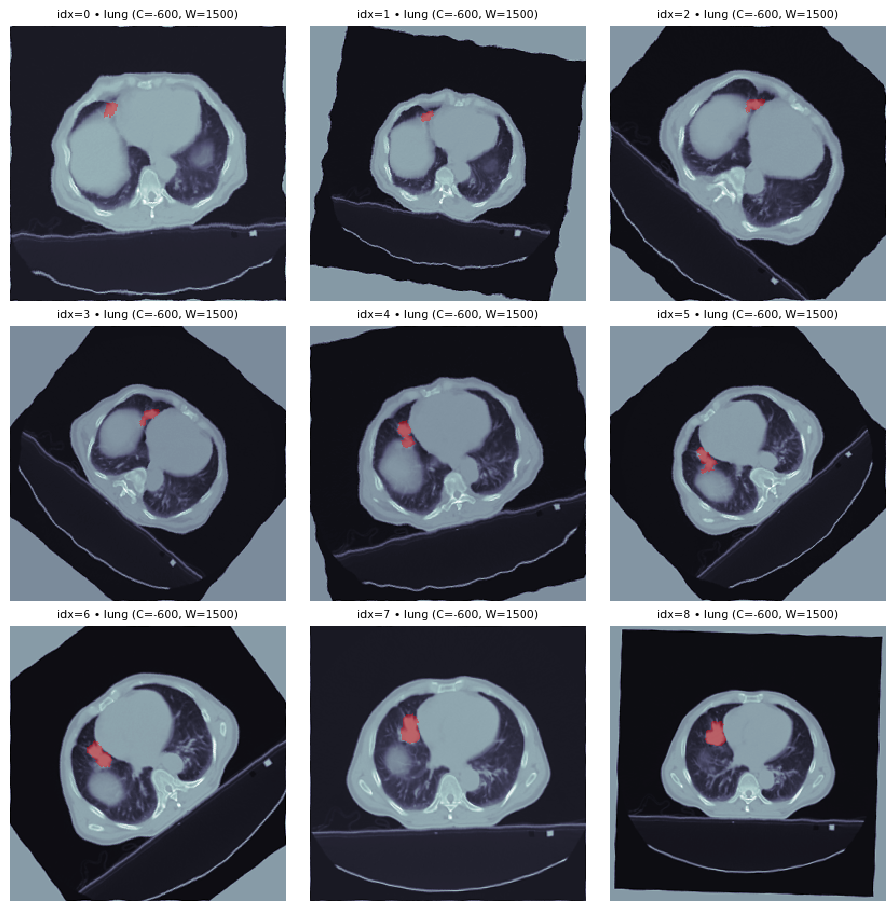

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def reorient_2d(a: np.ndarray) -> np.ndarray:
    # flip vertically, then rotate -90° (clockwise)
    return np.rot90(np.flipud(a), k=3)

def window_hu(img, center, width):
    lo = center - width/2.0
    hi = center + width/2.0
    img = np.nan_to_num(img, nan=lo, posinf=hi, neginf=lo)
    img = np.clip(img, lo, hi)
    return (img - lo) / (hi - lo + 1e-8)  # normalize to [0,1]

# choose a preset
WINDOWS = {
    "lung":        (-600, 1500),
    "mediastinal": (  40,  400),
    "soft_tissue": (  50,  350),
}
preset = "lung"   # <- try "mediastinal" if too bright
C, W = WINDOWS[preset]

# grid of indices (first 9 or your own list)
idxs = list(range(min(len(dataset), 9)))

fig, axes = plt.subplots(3, 3, figsize=(9, 9), constrained_layout=True)
axes = axes.ravel()

for k, ax in enumerate(axes):
    ax.axis("off")
    if k >= len(idxs): continue

    slc, msk = dataset[idxs[k]]     # (1,H,W)
    img2d = np.squeeze(slc)
    m2d   = np.squeeze(msk)

    # reorient
    img_r = reorient_2d(img2d)
    msk_r = reorient_2d(m2d)

    # window using chosen preset (darker than percentile)
    disp = window_hu(img_r, center=C, width=W)

    ax.imshow(disp, cmap="bone", interpolation="none")
    if np.any(msk_r > 0):
        ax.imshow(np.ma.masked_where(msk_r <= 0, msk_r),
                  cmap="autumn", alpha=0.40, interpolation="nearest")
    ax.set_title(f"idx={idxs[k]} • {preset} (C={C}, W={W})", fontsize=8)

plt.show()